# Quantum Phase Estimation (QPE) for H₂ — **Noisy**

- Uses PennyLane and your harmonized project utilities
- Adds simple noise models (depolarizing and amplitude damping)
- Compares to Hartree–Fock (HF)
- Includes sweeps over noise strengths

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane import qchem
import sys, os, json
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))
from notebooks.qpe_utils import (
    plot_qpe_distribution,
    hartree_fock_energy,
    signature_hash,
    run_qpe,
    save_qpe_result,
    load_qpe_result,
)
from notebooks.vqe_utils import ensure_dirs, set_seed

set_seed(0)
ensure_dirs()

# Define H₂ molecule (bond length ~0.7414 Å, STO-3G)
symbols = ["H", "H"]
coordinates = np.array([[0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.7414]])  # Å
basis = "STO-3G"

# Molecular Hamiltonian
hamiltonian, num_qubits = qchem.molecular_hamiltonian(
    symbols, coordinates, charge=0, basis=basis
)

# Hartree–Fock reference occupation
electrons = 2
hf = qchem.hf_state(electrons, num_qubits)

print(f"Molecule: H₂  |  Basis: {basis}")
print(f"Number of qubits: {num_qubits}")
print(f"HF bitstring: {'|' + ''.join(str(b) for b in hf) + '⟩'}")


Molecule: H₂  |  Basis: STO-3G
Number of qubits: 4
HF bitstring: |1100⟩


In [2]:
# Core QPE parameters
molecule_name = "H2"
n_ancilla = 4      # Ancilla qubits for QPE register
t_evol = 1.0       # Evolution time in U = exp(-i*H*t)
trotter_steps = 2  # Trotterization depth
shots = 1000       # Sampling shots

# Noise configuration
noise_params = {
    "p_depol": 0.01,  # Depolarizing probability per application (per wire)
    "p_amp":   0.00,  # Amplitude damping probability per application (per wire)
}
print("Noise params:", noise_params)


Noise params: {'p_depol': 0.01, 'p_amp': 0.0}


In [3]:
# Build a unique signature so results cache separately per noise/params
sig = signature_hash(
    molecule=molecule_name,
    n_ancilla=n_ancilla,
    t=t_evol,
    noise=noise_params,
    shots=shots,
)

cached = load_qpe_result(molecule_name, sig)

if cached:
    print("✅ Loaded cached **noisy** QPE result.")
    result = cached
else:
    print("▶️ Running **noisy** QPE simulation...")
    result = run_qpe(
        hamiltonian=hamiltonian,
        hf_state=hf,
        n_ancilla=n_ancilla,
        t=t_evol,
        trotter_steps=trotter_steps,
        noise_params=noise_params,
        shots=shots,
        molecule_name=molecule_name,
    )
    save_qpe_result(result)

print("\n✅ QPE completed (noisy).")
print(f"Most probable bitstring: {result['best_bitstring']}")
print(f"Estimated phase: {result['phase']:.6f}")
print(f"Estimated energy: {result['energy']:.8f} Ha")


▶️ Running **noisy** QPE simulation...
Saved QPE result → /workspaces/Variational_Quantum_Eigensolver/notebooks/data/qpe_results/H2_QPE_9b61eae21c6e9f3d3a737592d5834d2e.json

✅ QPE completed (noisy).
Most probable bitstring: 0100
Estimated phase: 0.125000
Estimated energy: -0.78539816 Ha


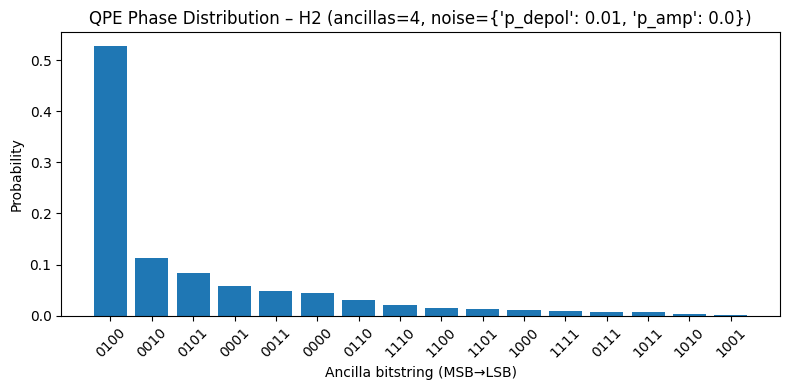

Saved plot → /workspaces/Variational_Quantum_Eigensolver/notebooks/plots/qpe/H2_QPE_4q.png


In [4]:
plot_qpe_distribution(result)


In [5]:
E_hf = hartree_fock_energy(hamiltonian, hf)
print(f"Hartree–Fock energy: {E_hf:.8f} Ha")
print(f"QPE (noisy) estimate: {result['energy']:.8f} Ha")
print(f"ΔE (QPE - HF): {result['energy'] - E_hf:+.8f} Ha")


Hartree–Fock energy: -0.88842304 Ha
QPE (noisy) estimate: -0.78539816 Ha
ΔE (QPE - HF): +0.10302488 Ha


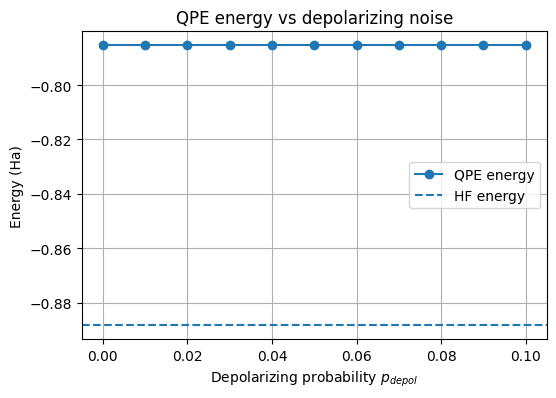

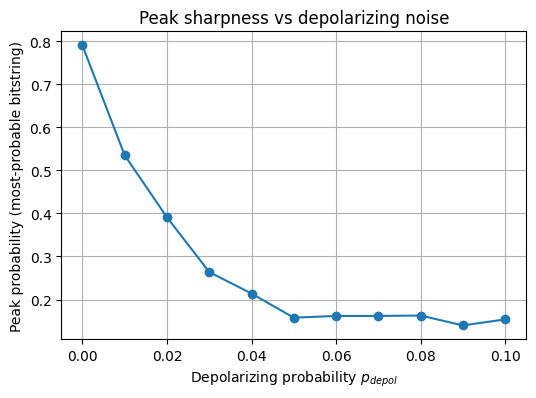

In [6]:
# Sweep depolarizing noise; keep amplitude damping off
p_depol_list = np.linspace(0.0, 0.1, 11)
energies_dep = []
success_prob_dep = []  # Probability mass at the most probable bitstring

for p in p_depol_list:
    r = run_qpe(
        hamiltonian=hamiltonian,
        hf_state=hf,
        n_ancilla=n_ancilla,
        t=t_evol,
        trotter_steps=trotter_steps,
        noise_params={"p_depol": float(p), "p_amp": 0.0},
        shots=shots,
        molecule_name=molecule_name,
    )
    energies_dep.append(r["energy"])
    success_prob_dep.append(r["probs"][r["best_bitstring"]])

energies_dep = np.array(energies_dep)
success_prob_dep = np.array(success_prob_dep)

# Plot energy vs depolarizing noise
plt.figure(figsize=(6,4))
plt.plot(p_depol_list, energies_dep, 'o-', label='QPE energy')
plt.axhline(E_hf, linestyle='--', label='HF energy')
plt.xlabel('Depolarizing probability $p_{depol}$')
plt.ylabel('Energy (Ha)')
plt.title('QPE energy vs depolarizing noise')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(p_depol_list, success_prob_dep, 'o-')
plt.xlabel('Depolarizing probability $p_{depol}$')
plt.ylabel('Peak probability (most-probable bitstring)')
plt.title('Peak sharpness vs depolarizing noise')
plt.grid(True)
plt.show()


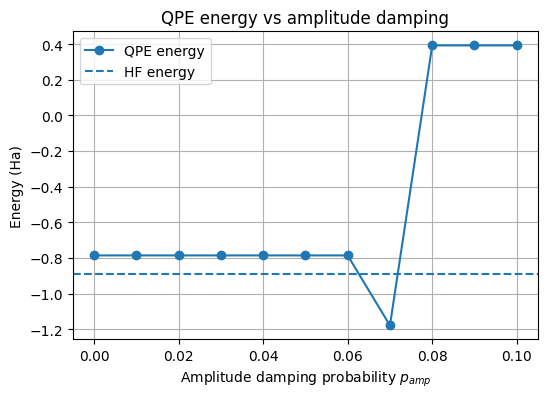

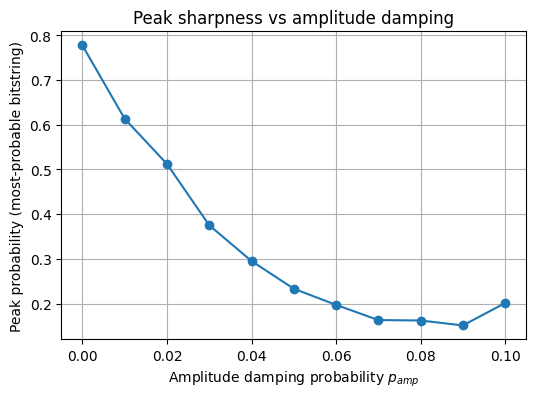

In [7]:
# Sweep amplitude damping; keep depolarizing off
p_amp_list = np.linspace(0.0, 0.1, 11)
energies_amp = []
success_prob_amp = []

for p in p_amp_list:
    r = run_qpe(
        hamiltonian=hamiltonian,
        hf_state=hf,
        n_ancilla=n_ancilla,
        t=t_evol,
        trotter_steps=trotter_steps,
        noise_params={"p_depol": 0.0, "p_amp": float(p)},
        shots=shots,
        molecule_name=molecule_name,
    )
    energies_amp.append(r["energy"])
    success_prob_amp.append(r["probs"][r["best_bitstring"]])

energies_amp = np.array(energies_amp)
success_prob_amp = np.array(success_prob_amp)

# Plot energy vs amplitude damping
plt.figure(figsize=(6,4))
plt.plot(p_amp_list, energies_amp, 'o-', label='QPE energy')
plt.axhline(E_hf, linestyle='--', label='HF energy')
plt.xlabel('Amplitude damping probability $p_{amp}$')
plt.ylabel('Energy (Ha)')
plt.title('QPE energy vs amplitude damping')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(p_amp_list, success_prob_amp, 'o-')
plt.xlabel('Amplitude damping probability $p_{amp}$')
plt.ylabel('Peak probability (most-probable bitstring)')
plt.title('Peak sharpness vs amplitude damping')
plt.grid(True)
plt.show()


In [ ]:
# Small 2D grid over depolarizing & amplitude damping to visualize degradation
p_grid = np.linspace(0.0, 0.03, 7)
E_map = np.zeros((len(p_grid), len(p_grid)))
Peak_map = np.zeros_like(E_map)

for i, pd in enumerate(p_grid):
    for j, pa in enumerate(p_grid):
        r = run_qpe(
            hamiltonian=hamiltonian,
            hf_state=hf,
            n_ancilla=n_ancilla,
            t=t_evol,
            trotter_steps=trotter_steps,
            noise_params={"p_depol": float(pd), "p_amp": float(pa)},
            shots=shots,
            molecule_name=molecule_name,
        )
        E_map[i, j] = r["energy"]
        Peak_map[i, j] = r["probs"][r["best_bitstring"]]

# Plot 2D heatmaps
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(E_map, origin='lower', extent=[p_grid[0], p_grid[-1], p_grid[0], p_grid[-1]], aspect='auto')
ax.set_xlabel('$p_{amp}$')
ax.set_ylabel('$p_{depol}$')
ax.set_title('QPE energy (Ha) over noise grid')
plt.colorbar(im, ax=ax, label='Energy (Ha)')
plt.show()

fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(Peak_map, origin='lower', extent=[p_grid[0], p_grid[-1], p_grid[0], p_grid[-1]], aspect='auto')
ax.set_xlabel('$p_{amp}$')
ax.set_ylabel('$p_{depol}$')
ax.set_title('Peak probability over noise grid')
plt.colorbar(im, ax=ax, label='Peak prob.')
plt.show()
